### Import Step

In [4]:
import requests
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score

In [22]:
# URL of the .db file hosted on GitHub
db_url = "https://raw.githubusercontent.com/brutus-the-homeschooler/Capstone/main/Database/acsse_2022.db"

# Download the .db file
response = requests.get(db_url)

# Save the .db file locally
with open("acsse_2022.db", "wb") as db_file:
    db_file.write(response.content)

# Connect to the SQLite database
conn = sqlite3.connect('acsse_2022.db')

# Query the 'census_data' table
census_data_df = pd.read_sql_query("SELECT * FROM census_data", conn)

# Query the 'place_dictionary' table
place_dict_df = pd.read_sql_query("SELECT * FROM place_dictionary", conn)

# Query the 'state_dictionary' table
#state_dict_df = pd.read_sql_query("SELECT * FROM state_dictionary", conn)

# Query the 'variable_dictionary' table
#variable_dict_df = pd.read_sql_query("SELECT * FROM variable_dictionary", conn)

# Close the connection
conn.close()

### Filter Variables

Based upon prior analysis, these 19 variables have been selected as reliable and interesting to study for the basis of this analysis.

In [23]:
# Define filter variables for estimates (ending with 'E')
filter_variables = [
    "K200101_001E", "K200101_002E", "K200101_003E", "K200201_002E", "K200301_002E",
    "K200501_002E", "K200801_002E", "K200901_003E", "K201401_002E", "K201501_007E",
    "K201501_008E", "K201601_002E", "K201702_006E", "K202101_006E", "K202301_004E",
    "K202301_007E", "K202502_002E", "K202505_004E", "K202701_006E"
]

### Find reliable places

This code block takes the variables listed above and calculates the coefficient of variation based on the measurement value and the measurement of error, both of which are provided within the dataset.

In [24]:
# Step 1: Find columns in census_data_df that match filter_variables for 'E' and their corresponding 'M'
estimate_cols = [col for col in census_data_df.columns if col in filter_variables]
moe_cols = [col[:-1] + 'M' for col in estimate_cols]

# Step 2: Calculate all CVs at once and store in new columns
for est_col, moe_col in zip(estimate_cols, moe_cols):
    if moe_col in census_data_df.columns:
        var_base = est_col[:-1]
        # Calculate CV for each row and add it as a separate column
        census_data_df[f'{var_base}_CV'] = (abs(census_data_df[moe_col]) / (1.645 * census_data_df[est_col])) * 100

# Step 3: Select CV columns and count how many have CV < 15 for each place-state pair
cv_columns = [col for col in census_data_df.columns if col.endswith('_CV')]
cv_data = census_data_df[['place', 'state'] + cv_columns].copy()

# Step 4: Group by 'place' and 'state' and count how many variables have a CV < 15 for each pair
cv_counts = (
    cv_data.melt(id_vars=['place', 'state'], value_vars=cv_columns, var_name='Variable', value_name='CV')
    .query('CV < 15')
    .groupby(['place', 'state'])
    .size()
    .reset_index(name='Count')
)

# Filter to rows where count of variables with CV < 15 is greater than 18
filtered_result_df = cv_counts[cv_counts['Count'] > 18]

# Step 5: Filter census_data_df based on filtered_result_df and select only the desired columns
filtered_census_data_df = census_data_df.merge(
    filtered_result_df[['place', 'state']].drop_duplicates(),
    on=['place', 'state'],
    how='inner'
)[['place', 'state'] + filter_variables]

### Make a backup just in case

In [26]:
data = filtered_census_data_df.copy()

### Scale the data

In [27]:
# Identify columns ending with 'E' for scaling
columns_to_scale = [col for col in data.columns if col.endswith('E')]

# Separate the identifier columns (place and state) and the columns to scale
data_identifiers = data[['place', 'state']]
data_to_scale = data[columns_to_scale]

# Scale the data
scaler = StandardScaler()
data_scaled_df = pd.DataFrame(scaler.fit_transform(data_to_scale), columns=columns_to_scale, index=data.index)

# Combine scaled columns with the identifiers (place and state)
data_final = pd.concat([data_identifiers, data_scaled_df], axis=1)

### Find optimal # for k

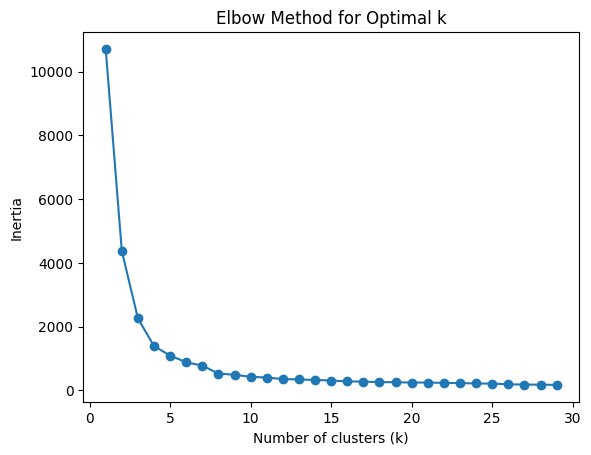

In [28]:
# Define range for number of clusters to test
K_range = range(1, 30)

# Calculate inertia for each k in the range
inertia = [KMeans(n_clusters=k, random_state=0).fit(data_scaled_df).inertia_ for k in K_range]

# Plot the Elbow Curve
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

We see the elbow starts between 8-12.

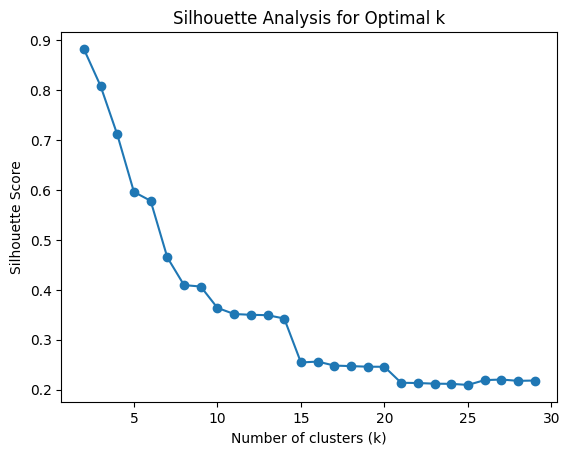

In [29]:
# Define range for number of clusters to test
K_range = range(2, 30)

# Calculate silhouette scores for each k in the range
silhouette_scores = [
    silhouette_score(data_scaled_df, KMeans(n_clusters=k, random_state=0).fit_predict(data_scaled_df))
    for k in K_range
]

# Plot silhouette scores
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()


The silhouette analysis shows that the silhouette score declines sharply between
𝑘
=
3 and
𝑘
=
6
, but it stabilizes somewhat around
𝑘
=
8
 to
𝑘
=
10
, supporting that
𝑘
=
10
could be a reasonable choice for clustering

In [30]:
# Fit KMeans model with the chosen number of clusters
k_optimal = 10  # Replace with the chosen optimal number of clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=0)
data_final['Cluster'] = kmeans.fit_predict(data_final)

In [31]:
# Find Dublin's cluster
Dublin_cluster = data_final[(data_final['state'] == '39') &
                                         (data_final['place'] == '22694')]['Cluster'].values[0]
print("Cluster for Dublin, Ohio:")
print(Dublin_cluster)

# Filter for rows where state is 39, which is Ohio
state_39_clusters = data_final[data_final['state'] == '39']

# Count the number of entries in each cluster for state 39
cluster_counts_state_39 = state_39_clusters['Cluster'].value_counts().sort_index()
print("\nCluster counts for Ohio:")
print(cluster_counts_state_39)

# Count the number of entries in each cluster overall
overall_cluster_counts = data_final['Cluster'].value_counts().sort_index()
print("\nOverall cluster counts:")
print(overall_cluster_counts)


Cluster for Dublin, Ohio:
0

Cluster counts for Ohio:
Cluster
0    1
1    1
3    2
5    1
6    1
7    3
9    1
Name: count, dtype: int64

Overall cluster counts:
Cluster
0    66
1    39
2    50
3    73
4    48
5    56
6    62
7    76
8    49
9    45
Name: count, dtype: int64


We find that Dublin is in Cluster 0 along with 65 other places. Through the k-means clustering, we are able to bring down the possible sister cities to 65.

### Analyze Dublin's Cluster

In [32]:
# Regions are based off of those at
# https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

# Create a dictionary to map states to divisions

states_to_division = {

    'Connecticut':'New England','Maine':'New England','Massachusetts':'New England',
    'New Hampshire':'New England','Rhode Island':'New England','Vermont':'New England',

    'New Jersey': 'Middle Atlantic', 'Pennsylvania': 'Middle Atlantic','New York'	: 'Middle Atlantic',

    'Indiana': 'East North Central','Illinois': 'East North Central' ,'Michigan': 'East North Central',
    'Ohio': 'East North Central','Wisconsin': 'East North Central',

    'Iowa'	 :'West North Central','Nebraska'	:'West North Central','Kansas' 	:'West North Central',
    'North Dakota'	:'West North Central','Minnesota'	:'West North Central' ,'South Dakota'	:'West North Central',
    'Missouri':'West North Central',

    'Delaware' :'South Atlantic', 'District of Columbia'	:'South Atlantic',
    'Florida' :'South Atlantic','Georgia' :'South Atlantic','Maryland' :'South Atlantic',
    'North Carolina' :'South Atlantic','South Carolina' :'South Atlantic',
    'Virginia' :'South Atlantic','West Virginia' :'South Atlantic',

    'Alabama': 'East South Central','Kentucky': 'East South Central',
    'Mississippi': 'East South Central','Tennessee': 'East South Central',

    'Arkansas': 'West South Central', 'Louisiana': 'West South Central',
    'Oklahoma':'West South Central','Texas':'West South Central',

    'Arizona': 'Mountain', 'Colorado': 'Mountain','Idaho': 'Mountain', 'New Mexico': 'Mountain',
    'Montana': 'Mountain', 'Utah': 'Mountain','Nevada': 'Mountain','Wyoming': 'Mountain',

    'Washington': 'Pacific', 'Oregon': 'Pacific', 'California': 'Pacific','Alaska': 'Pacific', 'Hawaii': 'Pacific'}

division_to_region = {
   'New England':'Northeast','Middle Atlantic':'Northeast',
   'East North Central': 'Midwest', 'West North Central': 'Midwest',
   'South Atlantic': 'South', 'East South Central': 'South',  'West South Central': 'South',
   'Mountain': 'West', 'Pacific': 'West'}

In [33]:
# Merge place information into data_final
filtered_census_data_df = data_final.merge(
    place_dict_df[['place', 'state', 'City Name', 'State_Name']],
    on=['place', 'state'],
    how='inner'
)

# Map states to divisions and divisions to regions
filtered_census_data_df['Division'] = filtered_census_data_df['State_Name'].map(states_to_division)
filtered_census_data_df['Region'] = filtered_census_data_df['Division'].map(division_to_region)

# Identify the target cluster for state = 39 and place = 22694
target_cluster = filtered_census_data_df[
    (filtered_census_data_df['state'] == '39') &
    (filtered_census_data_df['place'] == '22694')
]['Cluster'].values[0]

# Filter for rows with the same cluster value
cluster_subset = filtered_census_data_df[filtered_census_data_df['Cluster'] == target_cluster]

# Group by State_Name, Region, and Division, and count occurrences
grouped_counts = {
    group_by: cluster_subset.groupby(group_by).size().reset_index(name='Count')
    for group_by in ['State_Name', 'Region', 'Division']
}

# Access individual group count DataFrames
counts_by_state = grouped_counts['State_Name']
counts_by_region = grouped_counts['Region']
counts_by_division = grouped_counts['Division']

# Display the result
print("Counts by State:")
print(counts_by_state)

print("\nCounts by Division:")
print(counts_by_division)

print("\nCounts by Region:")
print(counts_by_region)

Counts by State:
        State_Name  Count
0          Alabama      1
1          Arizona      4
2         Arkansas      2
3       California     12
4         Colorado      1
5          Florida      3
6          Georgia      1
7           Hawaii      1
8         Illinois      2
9          Indiana      3
10            Iowa      1
11        Maryland      2
12   Massachusetts      3
13        Michigan      2
14        Nebraska      1
15          Nevada      1
16  North Carolina      4
17    North Dakota      1
18            Ohio      1
19        Oklahoma      1
20          Oregon      1
21       Tennessee      2
22           Texas     10
23            Utah      1
24        Virginia      1
25      Washington      2
26       Wisconsin      2

Counts by Division:
             Division  Count
0  East North Central     10
1  East South Central      3
2            Mountain      7
3         New England      3
4             Pacific     16
5      South Atlantic     11
6  West North Central      3
7 

### Below is the same k-means clustering based on the survey data where the values are the percentage compared to the total population variable. For example .487 for Male means the population is 48.7% Male.

In [5]:
# Import the CSV file into a DataFrame
census_clean_df = pd.read_csv('/content/CensusData_Clean.csv')

# Preview the first few rows of the DataFrame
#print(census_clean_df.head())

In [6]:
# Identify columns ending with 'E' for scaling
columns_to_scale_2 = [col for col in census_clean_df.columns if col not in ['place', 'state']]

# Separate the identifier columns ('place' and 'state') and the columns to scale
data_identifiers_2 = census_clean_df[['place', 'state']]
data_to_scale_2 = census_clean_df[columns_to_scale_2]

# Scale the data
scaler = StandardScaler()
data_scaled_df_2 = pd.DataFrame(scaler.fit_transform(data_to_scale_2), columns=columns_to_scale_2, index=census_clean_df.index)

# Combine scaled columns with the identifiers (place and state)
data_final_2 = pd.concat([data_identifiers_2, data_scaled_df_2], axis=1)

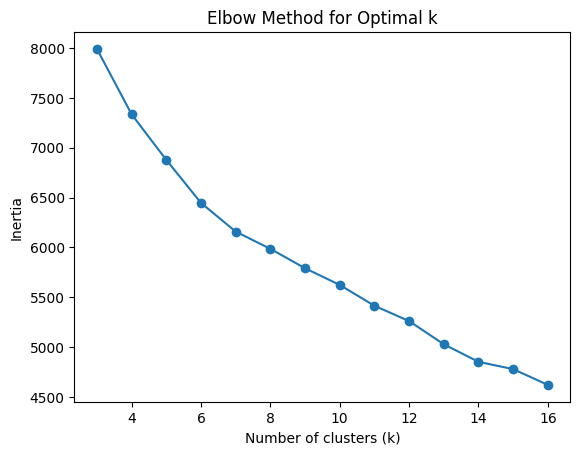

In [7]:
# Define range for number of clusters to test
K_range = range(3,17)

# Calculate inertia for each k in the range
inertia = [KMeans(n_clusters=k, random_state=0).fit(data_scaled_df_2).inertia_ for k in K_range]

# Plot the Elbow Curve
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

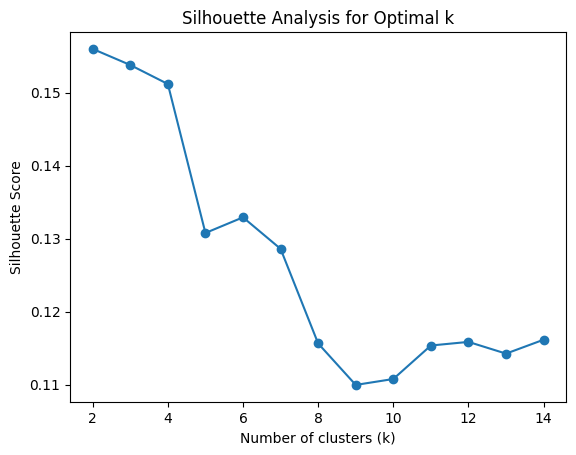

In [8]:
# Define range for number of clusters to test
K_range = range(2, 15)

# Calculate silhouette scores for each k in the range
silhouette_scores = [
    silhouette_score(data_scaled_df_2, KMeans(n_clusters=k, random_state=0).fit_predict(data_scaled_df_2))
    for k in K_range
]

# Plot silhouette scores
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [9]:
# Drop non-numeric columns
data_numeric = data_final_2.drop(columns=['place', 'state'])

In [10]:
np.random.seed(250)
k_optimal =6  # Replace with the chosen optimal number of clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=250)

# Fit and predict clusters
clusters = kmeans.fit_predict(data_numeric)

# Add the cluster assignments back to the numeric DataFrame
data_numeric['Cluster'] = clusters

In [11]:
# Add 'place' and 'state' back to the DataFrame
data_final_2 = pd.concat([data_final_2[['place', 'state']], data_numeric], axis=1)

# View the final DataFrame with clusters
print(data_final_2.head())

             place    state  TotalPop      Male    Female     White  \
0      Auburn city  Alabama -0.325401 -0.234156  0.234156  0.579360   
1  Birmingham city  Alabama  0.094120 -1.449736  1.449736 -1.844139   
2      Dothan city  Alabama -0.359603 -1.020961  1.020961  0.070197   
3      Hoover city  Alabama -0.280623 -0.702540  0.702540  0.829736   
4  Huntsville city  Alabama  0.187909  0.307341 -0.307341  0.070966   

   NonHispanic  USCitizen  Commute_DriveAlone  Family_Married  ...  \
0     0.900989   0.168476            0.721837       -0.691961  ...   
1     1.021659   0.820438            0.030834       -2.229599  ...   
2     0.918836   1.032370            0.979756       -0.683772  ...   
3     0.844354   0.761495            0.849168        1.254567  ...   
4     0.844248   0.906841            1.140459       -0.257965  ...   

   Eduction_GraduateProf  Household_English  PovertyLvl_2andOver  NonVeteran  \
0               0.625577           0.516186            -1.197631    0.97

In [12]:
# Find Dublin's cluster
Dublin_cluster = data_final_2[(data_final_2['state'] == 'Ohio') &
                                         (data_final_2['place'] == 'Dublin city')]['Cluster'].values[0]
print("Cluster for Dublin, Ohio:")
print(Dublin_cluster)

# Filter for rows where state is 39, which is Ohio
state_39_clusters = data_final_2[data_final_2['state'] == 'Ohio']

# Count the number of entries in each cluster for state 39
cluster_counts_state_39 = state_39_clusters['Cluster'].value_counts().sort_index()
print("\nCluster counts for Ohio:")
print(cluster_counts_state_39)

# Count the number of entries in each cluster overall
overall_cluster_counts = data_final_2['Cluster'].value_counts().sort_index()
print("\nOverall cluster counts:")
print(overall_cluster_counts)

Cluster for Dublin, Ohio:
3

Cluster counts for Ohio:
Cluster
2    3
3    2
4    1
5    4
Name: count, dtype: int64

Overall cluster counts:
Cluster
0     52
1    116
2    148
3     92
4     39
5    117
Name: count, dtype: int64


In [15]:
# Map Division and Region
data_final_2['Division'] = data_final_2['state'].map(states_to_division)
data_final_2['Region'] = data_final_2['Division'].map(division_to_region)

# Find Dublin, Ohio cluster
target_cluster = data_final_2[
    (data_final_2['state'] == 'Ohio') &
    (data_final_2['place'] == 'Dublin city')
]['Cluster'].values[0]

# Filter for rows with the same cluster value
cluster_subset_2 = data_final_2[data_final_2['Cluster'] == target_cluster]

# Group by State_Name, Region, and Division, and count occurrences
grouped_counts_2 = {
    group_by: cluster_subset_2.groupby(group_by).size().reset_index(name='Count')
    for group_by in ['state', 'Region', 'Division']
}

# Access individual group count DataFrames
counts_by_state_2 = grouped_counts_2['state']
counts_by_region_2 = grouped_counts_2['Region']
counts_by_division_2 = grouped_counts_2['Division']

# Display the result
print("Counts by State:")
print(counts_by_state_2)

print("\nCounts by Division:")
print(counts_by_division_2)

print("\nCounts by Region:")
print(counts_by_region_2)

Counts by State:
             state  Count
0          Alabama      2
1          Arizona      6
2       California     18
3         Colorado      3
4          Florida      6
5          Georgia      6
6           Hawaii      1
7         Illinois      8
8          Indiana      1
9         Maryland      5
10   Massachusetts      1
11        Michigan      4
12       Minnesota      5
13        Missouri      1
14        New York      1
15  North Carolina      2
16            Ohio      2
17          Oregon      2
18  South Carolina      1
19       Tennessee      2
20           Texas      9
21        Virginia      4
22      Washington      2

Counts by Division:
             Division  Count
0  East North Central     15
1  East South Central      4
2     Middle Atlantic      1
3            Mountain      9
4         New England      1
5             Pacific     23
6      South Atlantic     24
7  West North Central      6
8  West South Central      9

Counts by Region:
      Region  Count
0    Midw

In [16]:
data_numeric

,TotalPop,Male,Female,White,NonHispanic,USCitizen,Commute_DriveAlone,Family_Married,EnrolledSchool_Over3Yrs,Education_Bachelors,Eduction_GraduateProf,Household_English,PovertyLvl_2andOver,NonVeteran,Employed,NotLaborForce,House_OwnerOccupied,House_Built80to99,HealthIns_Covered,Cluster
0,-0.325401,-0.234156,0.234156,0.579360,0.900989,0.168476,0.721837,-0.691961,4.108962,-0.419886,0.625577,0.516186,-1.197631,0.977014,-0.348837,1.254508,-0.808182,-0.001011,1.759790,4
1,0.094120,-1.449736,1.449736,-1.844139,1.021659,0.820438,0.030834,-2.229599,-0.186067,-0.910451,-0.778347,1.620394,-2.535192,0.481275,-1.164546,1.333946,-0.818702,-1.004822,-0.515075,5
2,-0.359603,-1.020961,1.020961,0.070197,0.918836,1.032370,0.979756,-0.683772,-0.306189,-1.145462,-0.833127,1.015931,-0.959066,-1.114551,-1.264880,0.893057,0.031629,0.131211,-1.517278,5
3,-0.280623,-0.702540,0.702540,0.829736,0.844354,0.761495,0.849168,1.254567,-0.271534,0.940832,1.222545,0.891101,1.106191,-0.791548,0.402615,-0.630281,1.097359,0.831652,-0.545186,3
4,0.187909,0.307341,-0.307341,0.070966,0.844248,0.906841,1.140459,-0.257965,-0.024225,0.019047,0.384977,1.267794,-0.438964,-0.474508,-0.029941,0.251193,0.249701,-0.114009,0.075125,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,1.417305,-0.445344,0.445344,-1.210280,-0.069236,0.170535,-0.480701,-2.040832,0.308218,-1.286676,-0.976019,0.583219,-1.632582,-0.166840,-0.579283,0.010775,-1.308977,-1.936215,-0.163932,5
560,-0.468565,-0.386356,0.386356,1.667255,0.903232,1.122137,1.179045,1.442038,-0.627518,0.462461,-0.158007,1.031494,1.137915,0.117793,0.012624,0.370967,1.783986,-0.399148,-0.493939,2
561,-0.376154,1.111080,-1.111080,1.283361,1.011181,1.121677,1.168340,-1.075338,0.086389,-1.435498,-1.071678,1.235021,-1.205612,1.577192,0.786709,0.752748,-0.148588,-0.714823,0.498865,5
562,-0.359815,1.447032,-1.447032,1.112551,0.487703,0.914848,2.121489,-0.089473,-0.265472,0.375186,-0.663771,1.191411,0.347854,0.628873,1.098439,-0.992526,0.704288,0.255174,0.621667,2


In [17]:
# Only include numeric data
data_numeric = data_final_2.select_dtypes(include=['number'])

data_numeric = data_numeric.drop(columns=['Cluster'])

# Assuming you have already fitted the k-means model on your data
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data_numeric.columns)

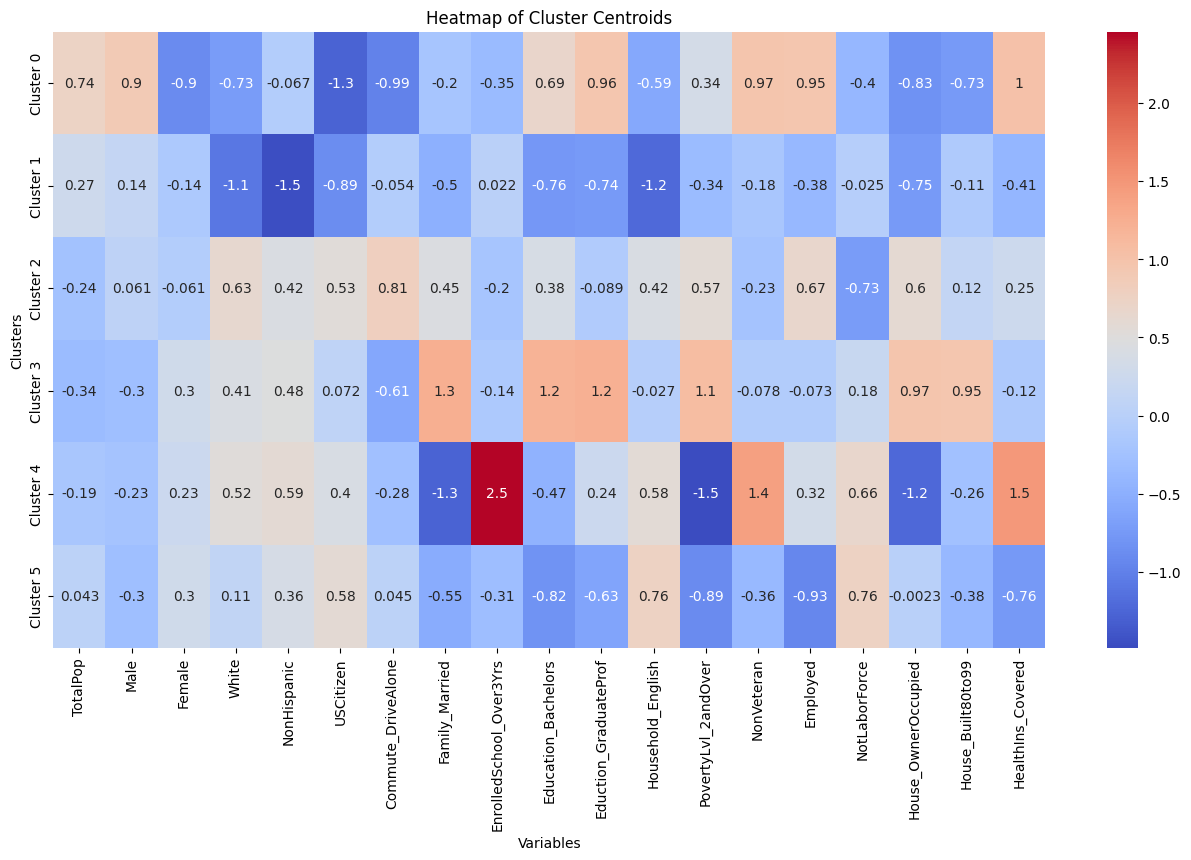

In [18]:
# Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(centroids, annot=True, cmap='coolwarm', xticklabels=data_numeric.columns, yticklabels=[f"Cluster {i}" for i in range(len(centroids))])
plt.title("Heatmap of Cluster Centroids")
plt.xlabel("Variables")
plt.ylabel("Clusters")
plt.show()


The heatmap of cluster centroids provides key insights into the characteristics of the variables within each cluster. Cluster 5 stands out with higher values for variables such as House_Built80to99, HealthIns_Covered, and Education_Bachelors, indicating that these features are particularly dominant in this cluster. In contrast, other clusters exhibit lower values for these variables, suggesting different population dynamics or socioeconomic trends. Cluster 5 also shows relatively high proportions of variables like Commute_DriveAlone and Employed, reinforcing its unique profile compared to the others. The visual gradient across the heatmap highlights the variability in each variable's influence on the clusters, with some variables such as PovertyLvl_2andOver and NonVeteran exhibiting consistently lower values across clusters. This variability allows for clear distinctions between clusters and helps in understanding the dominant traits that define Cluster 5 compared to the rest.

In [19]:
# `kmeans.cluster_centers_` contains the centroids
# Add 'Cluster' column to the dataset if it's not already there
data_final_2['Cluster'] = kmeans.labels_

# Filter Cluster 5 data
cluster_3 = data_final_2[data_final_2['Cluster'] == 3]

# Get the centroid of Cluster 3
cluster_3_centroid = kmeans.cluster_centers_[3]  # Replace '3' with the cluster index for Cluster for Dublin
# Identify the numeric columns used in k-means clustering
columns_used_in_kmeans = data_numeric.columns  # Replace with the actual column names used in clustering

# Calculate Euclidean distance to the centroid for each point in Cluster 3
cluster_3['Distance_to_Centroid'] = cluster_3[columns_used_in_kmeans].apply(
    lambda row: euclidean(row, cluster_3_centroid),
    axis=1
)

# Check if Dublin City, OH is in Cluster 3
dublin_row = cluster_3[(cluster_3['place'] == 'Dublin city') & (cluster_3['state'] == 'Ohio')]

<ipython-input-19-fdef7175554c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_3['Distance_to_Centroid'] = cluster_3[columns_used_in_kmeans].apply(


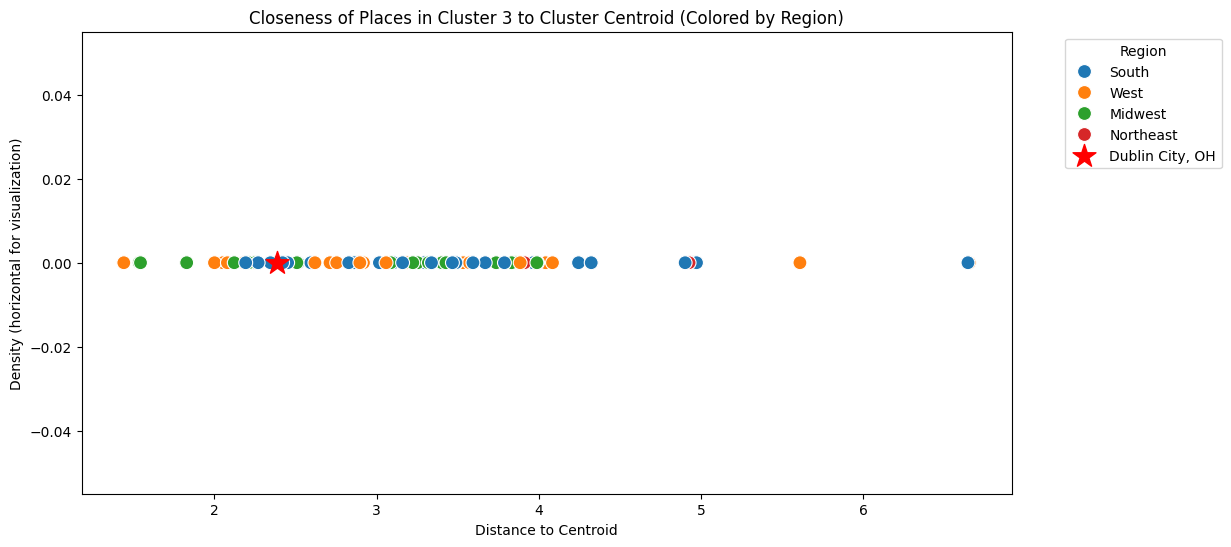

In [20]:
# Scatterplot for Cluster 5, colored by Region
plt.figure(figsize=(12, 6))

# Scatterplot with colors based on the 'Region' column
sns.scatterplot(
    x=cluster_3['Distance_to_Centroid'],
    y=[0] * len(cluster_3),  # Keep points horizontally aligned for clarity
    hue=cluster_3['Region'],  # Color by Region
    palette='tab10',          # Use a distinct color palette
    s=100                     # Size of points
)

# Highlight Dublin City, OH
plt.scatter(
    dublin_row['Distance_to_Centroid'],
    [0],
    color='red',
    marker='*',
    s=300,
    label='Dublin City, OH'
)

# Customize the plot
plt.title('Closeness of Places in Cluster 3 to Cluster Centroid (Colored by Region)')
plt.xlabel('Distance to Centroid')
plt.ylabel('Density (horizontal for visualization)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Dublin City, OH (marked by the red star) is positioned relatively close to the centroid of Cluster 5, making it a strong representative of the cluster's overall characteristics. Its location on the lower end of the distance spectrum suggests that it is central to the cluster in terms of feature similarity. The points in the scatterplot are spread along the X-axis, which represents their Euclidean distances to the centroid; smaller distances indicate a closer alignment with the core features of Cluster 5. The Y-axis, meanwhile, serves purely for visual separation. Most places in Cluster 5 are grouped between distances of approximately 2 and 4, indicating a relatively compact cluster with a clear core, though there are a few outliers beyond a distance of 6. These outliers differ more significantly from the centroid and may not share as many characteristics with Dublin City or other central members of the cluster.

### Comparison between the two methods

In [34]:
print("Counts by Region (Using raw values):")
print(counts_by_region)

print("\nCounts by Region (using percentages):")
print(counts_by_region_2)

Counts by Region (Using raw values):
      Region  Count
0    Midwest     13
1  Northeast      3
2      South     27
3       West     23

Counts by Region (using percentages):
      Region  Count
0    Midwest     21
1  Northeast      2
2      South     37
3       West     32


Both methods highlight a strong reliance on the West and South regions, followed by the Midwest. Notably, Dublin, Ohio, is located in the Midwest region. This raises interesting questions about how potential sister cities could be concentrated in the South or West regions rather than within the same geographical area. The relatively high counts in the South and West suggest that cities in these regions may share similar socioeconomic or demographic characteristics with Dublin, Ohio, despite being geographically distant.

Paired with the earlier proximity-to-centroid visual analysis, this lends further support to examining the unique variables that position certain cities as closer matches to Dublin within the cluster. It also emphasizes the importance of expanding the analysis to include region-specific trends, such as population density, economic indicators, or cultural factors, that might influence cluster placement. This insight opens up opportunities to refine the analysis by incorporating additional regional variables or weighting certain features to better reflect Dublin's specific profile.

By combining the cluster proximity data with these regional distributions, the analysis gains a multidimensional perspective, helping narrow down potential sister cities while uncovering the broader relationships between regions and their shared attributes with Dublin, Ohio. This layered approach could significantly aid in making more informed decisions about which cities best align with Dublin's characteristics and priorities.

In [35]:
print("Counts by Division (Using raw values):")
print(counts_by_division)
print("\nCounts by Division (using percentages):")
print(counts_by_division_2)

Counts by Division (Using raw values):
             Division  Count
0  East North Central     10
1  East South Central      3
2            Mountain      7
3         New England      3
4             Pacific     16
5      South Atlantic     11
6  West North Central      3
7  West South Central     13

Counts by Division (using percentages):
             Division  Count
0  East North Central     15
1  East South Central      4
2     Middle Atlantic      1
3            Mountain      9
4         New England      1
5             Pacific     23
6      South Atlantic     24
7  West North Central      6
8  West South Central      9


The division-level analysis closely mirrors the trends observed at the region level, with divisions like the Pacific, South Atlantic, and West South Central standing out in the upper bands. Interestingly, the East North Central division, which includes Ohio (and therefore Dublin), also ranks prominently, suggesting potential sister cities may exist both within Dublin's immediate geographic area and beyond.

The presence of divisions like Pacific and South Atlantic in the upper band indicates that cities in these divisions may share characteristics with Dublin despite being geographically distant. This underscores the value of exploring similarities beyond immediate proximity, such as economic indicators, demographic patterns, or cultural traits.

While the analysis reveals strong possibilities within the East North Central division—aligning with the expected regional proximity of Dublin—this is balanced by notable representation from divisions in the South and West. This further validates the need for a holistic approach that combines geographic proximity with clustering variables to identify sister cities that align with Dublin’s unique attributes.